# Data Science 403 Project Update 3

### The information in sections "Results and Evaluation" and "Future Work" are new for this update
**I edited "Model Selection Results".

Scroll to the bottom for these sections



In [1]:
#import statements
import earthaccess
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import random
import rasterio
import xarray as xr
import rioxarray
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn.metrics import accuracy_score
import seaborn as sns

## Data Aquisition

### BedMachine Antarctica

In [2]:
#log into Earthdata to get dataset
earthaccess.login()
#find bedmachine on earthdata
path= earthaccess.search_data(doi='10.5067/FPSU0V1MWUB6', cloud_hosted=True,bounding_box=(1, -89, -1, -89))
#open data granules
file=earthaccess.open(path)

Enter your Earthdata Login username:  anaHorne
Enter your Earthdata password:  ········


Granules found: 1
Opening 1 granules, approx size: 0.79 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

BedMachine data can be accessed via [this link]( https://www.doi.org/10.5067/FPSU0V1MWUB6), and you are able to create an Earthdata login for free. The features of the data I plan to use are Firn, Surface, Thickness and bed. A more indepth review of this dataset can be found [here](https://nsidc.org/sites/default/files/documents/user-guide/nsidc-0756-v003-userguide.pdf). There are no limits on how I use this data, but as we will see in the preprocessing stage, the data does not span the entire Antarctica continent.      

In [3]:
#open dataset, its a netCDF, so we first read it into an xarray
ds=xr.open_dataset(file[0],engine='h5netcdf')
bedMach=ds

In [4]:
#convert to dataframe
bedMachDF=ds.to_dataframe()
bedMachDF=bedMachDF.reset_index()
bedMachDF

,x,y,mapping,mask,firn,surface,thickness,bed,errbed,source,dataid,geoid
0,-3333000,3333000,b'',0,0.0,0.0,0.0,-5915.544434,NaN,1,0,-1
1,-3333000,3332500,b'',0,0.0,0.0,0.0,-5911.253418,NaN,1,0,-1
2,-3333000,3332000,b'',0,0.0,0.0,0.0,-5907.299805,NaN,1,0,-1
3,-3333000,3331500,b'',0,0.0,0.0,0.0,-5903.499512,NaN,1,0,-1
4,-3333000,3331000,b'',0,0.0,0.0,0.0,-5899.804688,NaN,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
177768884,3333000,-3331000,b'',0,0.0,0.0,0.0,-3663.762451,NaN,1,0,-19
177768885,3333000,-3331500,b'',0,0.0,0.0,0.0,-3664.628418,NaN,1,0,-19
177768886,3333000,-3332000,b'',0,0.0,0.0,0.0,-3665.332764,NaN,1,0,-19
177768887,3333000,-3332500,b'',0,0.0,0.0,0.0,-3665.390381,NaN,1,0,-19


The bedMachine pandas dataframe will be used to look at the data only. When we work with the data in our model, we will use an Xarray Dataset

### Grounding Line

In [5]:
#get grounding line, where ice transitions from ground to floating ice
groundLine=gpd.read_file("Antarctica_masks\scripps_antarctica_polygons_v1.shp")
landice = groundLine[groundLine['Id_text'] == 'Grounded ice or land']

The grounding line is where land ice stops and floating ice begins, we can think of it as the coastal line of Antarctica. The data can be accessed at [this link](https://doi.pangaea.de/10.1594/PANGAEA.819147), from the Scripps Institution of Oceanography. Subglacial lakes don't exist under floating ice, so we are interested in land ice areas, thus we need to clip our datasets to the grounding line.  

### Confirmed Subglacial Lakes

In [6]:
#get subglacial lake outlines, this data is downloaded from my research advisor's code
df=pd.read_csv('outlines.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
outlines=gpd.GeoDataFrame(df)
outlines

,name,geometry,area (m^2),perimeter (m),cite
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,51147.562479,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.240, -842354.948...",1.072249e+08,37249.152584,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,44183.483257,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,62680.016773,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-858067.460 -573467.564, -858714.391...",3.923966e+08,73686.203194,"Smith and others, 2009, J. Glac., doi:10.3189/..."
...,...,...,...,...,...
126,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,31952.842516,"Smith and others, 2009, J. Glac., doi:10.3189/..."
127,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,32373.996995,"Smith and others, 2009, J. Glac., doi:10.3189/..."
128,Whillans_8,"POLYGON ((-654478.748 -281124.560, -653777.327...",1.625714e+08,45873.974279,"Smith and others, 2009, J. Glac., doi:10.3189/..."
129,Wilkes_1,"POLYGON ((2214185.180 -666018.604, 2214317.389...",5.880773e+08,89565.314574,"Smith and others, 2009, J. Glac., doi:10.3189/..."


I obtained this csv from code written by my research advisor Wilson Sauthoff, who contributed to a [Github repository](https://github.com/mrsiegfried/Siegfried2021-GRL/blob/1.0/data/outlines/SiegfriedFricker2018-outlines.h5) that pulls from a paper [(Siegfried & Fricker 2021)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL091089). I imported directly from a csv instead of importing the code from the github because it is cleaner and is better suited for the scope of this project. If needed I can share this csv with you. The data contains the areas, represented by polygons, of confirmed subglacial lakes. I will use this data as one part of my 'target' data. 

### Not Subglacial Lakes

In [7]:
#this data also came from my research advisors code
df = pd.read_csv('nonlakePoint.csv', header=None)
coordArray=df.to_numpy()
d=pd.read_csv('nonlakePTS.csv')
nonlakeGDF= gpd.GeoDataFrame(d)
nonlakeGDF['geometry']=gpd.GeoSeries.from_wkt(nonlakeGDF['geometry'])
nonlakeGDF

,name,geometry,type
0,sampling_point_01,POINT (1392000.000 -34500.000),nonlake
1,sampling_point_02,POINT (1175000.000 393000.000),nonlake
2,sampling_point_03,POINT (1746500.000 -1128000.000),nonlake
3,sampling_point_04,POINT (705500.000 -1992000.000),nonlake
4,sampling_point_05,POINT (1326000.000 -1626500.000),nonlake
...,...,...,...
257,sampling_point_258,POINT (2095000.000 -985000.000),nonlake
258,sampling_point_259,POINT (1837000.000 -204500.000),nonlake
259,sampling_point_260,POINT (377500.000 1067500.000),nonlake
260,sampling_point_261,POINT (892500.000 -2042500.000),nonlake


Similar to the confirmed lakes, the non-subglacial lakes csv was obtained from code written by Wilson Sauthoff. The csv contains x, y coordinates of places we know there is not a subglacial lake. These coordinates were created/found by taking a simple random sample of Antarctica with areas of confirmed and suspected lakes removed. This data will be used as one part of my 'target' data.

## Data Preprocessing - Creating our Target Dataset

In [8]:
bedMachDF.describe()

,x,y,mask,firn,surface,thickness,bed,errbed,source,dataid,geoid
count,1.777689e+08,1.777689e+08,1.777689e+08,1.777689e+08,1.777689e+08,1.777689e+08,1.777689e+08,8.671841e+07,1.777689e+08,1.777689e+08,1.777689e+08
mean,0.000000e+00,0.000000e+00,6.449904e-01,7.101744e+00,5.955841e+02,5.885281e+02,-2.522410e+03,8.530916e+01,2.098177e+00,7.814979e-02,-1.047928e+01
std,1.924453e+06,1.924453e+06,9.887093e-01,9.833180e+00,9.618719e+02,9.823881e+02,1.779537e+03,1.341589e+02,1.795936e+00,6.567883e-01,2.780247e+01
min,-3.333000e+06,-3.333000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.166315e+03,1.000000e+01,1.000000e+00,0.000000e+00,-6.600000e+01
25%,-1.666500e+06,-1.666500e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.352919e+03,1.000000e+01,1.000000e+00,0.000000e+00,-3.300000e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.185895e+03,3.300000e+01,1.000000e+00,0.000000e+00,-1.400000e+01
75%,1.666500e+06,1.666500e+06,2.000000e+00,1.680822e+01,5.417394e+02,6.871041e+02,-4.439653e+02,9.500000e+01,5.000000e+00,0.000000e+00,1.500000e+01
max,3.333000e+06,3.333000e+06,4.000000e+00,5.092118e+01,4.818156e+03,4.822795e+03,4.818156e+03,1.000000e+03,1.000000e+01,1.000000e+01,5.200000e+01


We see that for the firn, surface, and thickness, alot of values are $0$. This could be due to lack of data. The data in this set is derived from various flight paths over Antarctica, but due to weather conditions and fuel limitations, there are some geographic regions that do not have any data.


In [9]:
#clip data to grounding line, clip to coast line
bedMach.rio.write_crs("epsg:3031", inplace=True)
nonlake = bedMach.surface.rio.clip(landice.geometry.values, landice.crs)

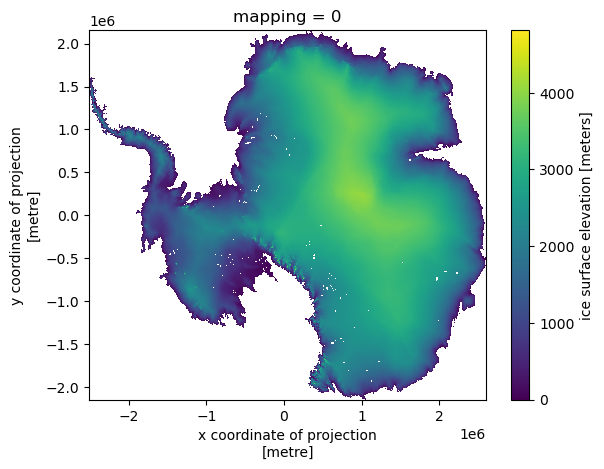

In [10]:
#image of where confirmed lakes are, we will use this as our 'target'
lakes = nonlake.rio.clip(outlines.geometry.values, outlines.crs, invert=True)
lakes.plot()
plt.savefig("lake.png")

In [11]:
#remove unnecessary columns from our outlines gpd
outlines=outlines.drop(columns=['name', 'area (m^2)', 'perimeter (m)', 'cite'])
outlines

,geometry
0,"POLYGON ((-792264.327 -691480.857, -791281.458..."
1,"POLYGON ((-842788.063 -708464.240, -842354.948..."
2,"POLYGON ((-874893.221 -654533.044, -876415.673..."
3,"POLYGON ((-828821.778 -584874.415, -828822.032..."
4,"POLYGON ((-858067.460 -573467.564, -858714.391..."
...,...
126,"POLYGON ((-451544.869 -488823.261, -451209.964..."
127,"POLYGON ((-543163.376 -500759.165, -542800.367..."
128,"POLYGON ((-654478.748 -281124.560, -653777.327..."
129,"POLYGON ((2214185.180 -666018.604, 2214317.389..."


Now we have areas where we know a subglacial lake exists. Now we need areas where subglacial lakes do not exist. 

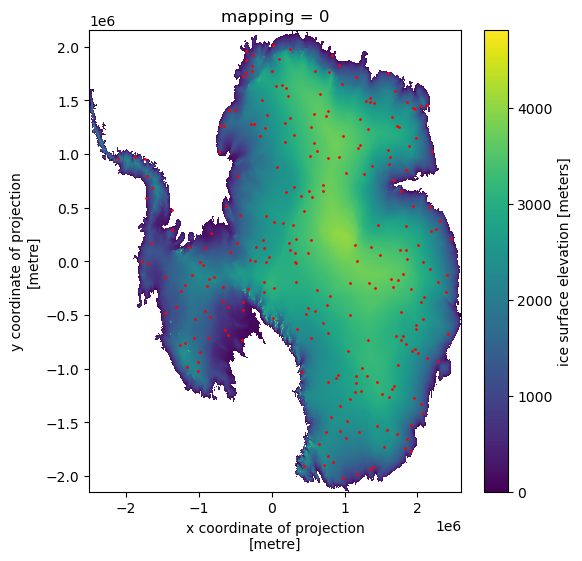

In [12]:
#image of where confirmed nonlakes are, we will use this as our 'target'
plt.figure(figsize=(6, 6))
nonlake.plot()
x, y = zip(*coordArray)
plt.scatter(x, y, s=1, color='red', marker='o')
plt.savefig("nonlake.png")

In [13]:
#remove unnecessary columns from our nonlakes gpd
nonlakeGDF=nonlakeGDF.drop(columns=['name'])
nonlakeGDF

,geometry,type
0,POINT (1392000.000 -34500.000),nonlake
1,POINT (1175000.000 393000.000),nonlake
2,POINT (1746500.000 -1128000.000),nonlake
3,POINT (705500.000 -1992000.000),nonlake
4,POINT (1326000.000 -1626500.000),nonlake
...,...,...
257,POINT (2095000.000 -985000.000),nonlake
258,POINT (1837000.000 -204500.000),nonlake
259,POINT (377500.000 1067500.000),nonlake
260,POINT (892500.000 -2042500.000),nonlake


# New Work

In [14]:
#add type column to our confirmed lakes
outlines['type']='lake'
outlines

,geometry,type
0,"POLYGON ((-792264.327 -691480.857, -791281.458...",lake
1,"POLYGON ((-842788.063 -708464.240, -842354.948...",lake
2,"POLYGON ((-874893.221 -654533.044, -876415.673...",lake
3,"POLYGON ((-828821.778 -584874.415, -828822.032...",lake
4,"POLYGON ((-858067.460 -573467.564, -858714.391...",lake
...,...,...
126,"POLYGON ((-451544.869 -488823.261, -451209.964...",lake
127,"POLYGON ((-543163.376 -500759.165, -542800.367...",lake
128,"POLYGON ((-654478.748 -281124.560, -653777.327...",lake
129,"POLYGON ((2214185.180 -666018.604, 2214317.389...",lake


In [15]:
#combine outlines (lake) gdf and nonlakeGDF
dataPoints=gpd.GeoDataFrame(pd.concat([outlines, nonlakeGDF]))
dataPoints

,geometry,type
0,"POLYGON ((-792264.327 -691480.857, -791281.458...",lake
1,"POLYGON ((-842788.063 -708464.240, -842354.948...",lake
2,"POLYGON ((-874893.221 -654533.044, -876415.673...",lake
3,"POLYGON ((-828821.778 -584874.415, -828822.032...",lake
4,"POLYGON ((-858067.460 -573467.564, -858714.391...",lake
...,...,...
257,POINT (2095000.000 -985000.000),nonlake
258,POINT (1837000.000 -204500.000),nonlake
259,POINT (377500.000 1067500.000),nonlake
260,POINT (892500.000 -2042500.000),nonlake


### Extract Features
We will loop through our bedMachine data to get 'sample values' for each of our bedmachine column headers (eg. 'firn') that are nearest our nonlake and lake points.

In [16]:
firnPoints=[]
surfPoints=[]
thickPoints=[]
bedPoints=[]

for i, row in dataPoints.iterrows():
    #get the center coord of our polygon and for POINT, will return our x, y values
    x, y= row.geometry.centroid.x, row.geometry.centroid.y
    
    #get sample points for interested features
    fValue = bedMach.firn.sel(x=x, y=y, method='nearest').values
    firnPoints.append(fValue)

    sValue = bedMach.surface.sel(x=x, y=y, method='nearest').values
    surfPoints.append(sValue)

    tValue = bedMach.thickness.sel(x=x, y=y, method='nearest').values
    thickPoints.append(tValue)

    bValue = bedMach.bed.sel(x=x, y=y, method='nearest').values
    bedPoints.append(bValue)

dataPoints['firn']=firnPoints
dataPoints['surface']=surfPoints
dataPoints['thickness']=thickPoints
dataPoints['bed']=bedPoints

dataPoints

,geometry,type,firn,surface,thickness,bed
0,"POLYGON ((-792264.327 -691480.857, -791281.458...",lake,13.148021,901.43097,2028.1741,-1126.7432
1,"POLYGON ((-842788.063 -708464.240, -842354.948...",lake,14.331444,1099.6376,2353.9333,-1254.2958
2,"POLYGON ((-874893.221 -654533.044, -876415.673...",lake,14.689835,1319.8147,2166.282,-846.4673
3,"POLYGON ((-828821.778 -584874.415, -828822.032...",lake,13.867694,1105.2688,2354.2532,-1248.9844
4,"POLYGON ((-858067.460 -573467.564, -858714.391...",lake,14.5030575,1236.2367,2253.6948,-1017.4581
...,...,...,...,...,...,...
257,POINT (2095000.000 -985000.000),nonlake,22.596476,1800.9246,2264.2122,-463.2876
258,POINT (1837000.000 -204500.000),nonlake,32.003468,3397.2966,3224.1729,173.12378
259,POINT (377500.000 1067500.000),nonlake,27.967264,3116.7546,2989.622,127.13257
260,POINT (892500.000 -2042500.000),nonlake,23.338541,1440.7144,1481.6494,-40.93506


We now have a complete dataset, **dataPoints**, with all our possible features and our target values.

## Data Preprocessing - Processing our Dataset

In [17]:
#get training data
X=dataPoints.drop(['geometry', 'type'], axis=1)
y=dataPoints['type']

In [18]:
print("Range of Firn values: ", dataPoints['firn'].min(), "-", dataPoints['firn'].max())
print("Range of Surface values: ", dataPoints['surface'].min(), "-", dataPoints['surface'].max())
print("Range of Thickness values: ", dataPoints['thickness'].min(), "-", dataPoints['thickness'].max())
print("Range of Bed Elevation values: ", dataPoints['bed'].min(), "-", dataPoints['bed'].max())

Range of Firn values:  0.0 - 38.092358
Range of Surface values:  68.64107 - 3967.4246
Range of Thickness values:  0.0 - 4126.224
Range of Bed Elevation values:  -2394.0723 - 2527.3254


Our features, **firn, surface, thickness** and **bed (elevation)** have very different magnitudes which could change the output of our model, so we need to scale our data.

In [19]:
#standard scaler
scaler=StandardScaler()
scaler.fit(X)

X=scaler.transform(X)

print("Range of Firn values: ", X[:,0].min(), "-", X[:,0].max())
print("Range of Surface values: ", X[:,1].min(), "-", X[:,1].max())
print("Range of Thickness values: ", X[:,2].min(), "-", X[:,2].max())
print("Range of Bed Elevation values: ", X[:,3].min(), "-", X[:,3].max())

Range of Firn values:  -3.380016217075171 - 2.3346407184174853
Range of Surface values:  -1.8365209102117386 - 1.9856554034418499
Range of Thickness values:  -2.3344268595166597 - 2.0720774203337613
Range of Bed Elevation values:  -2.801285065936646 - 3.613707416394037


In [20]:
#need dummy variables to visualize targets correctly
map={'lake':0, 'nonlake':1}
dumY=y.map(map)

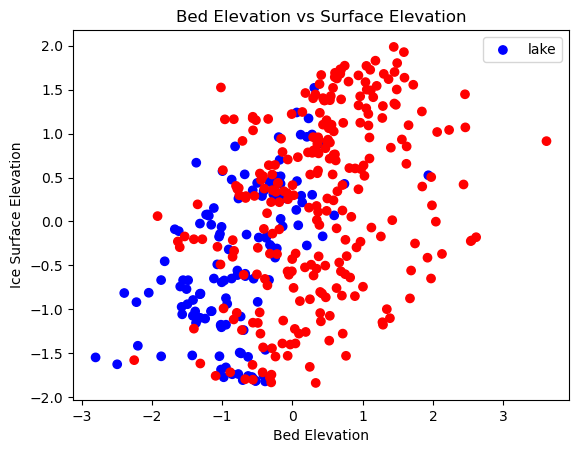

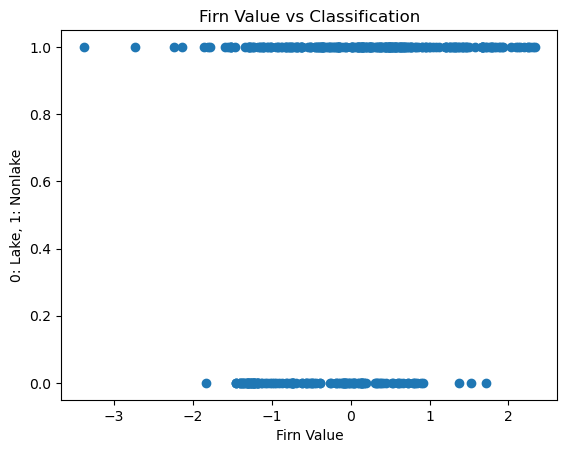

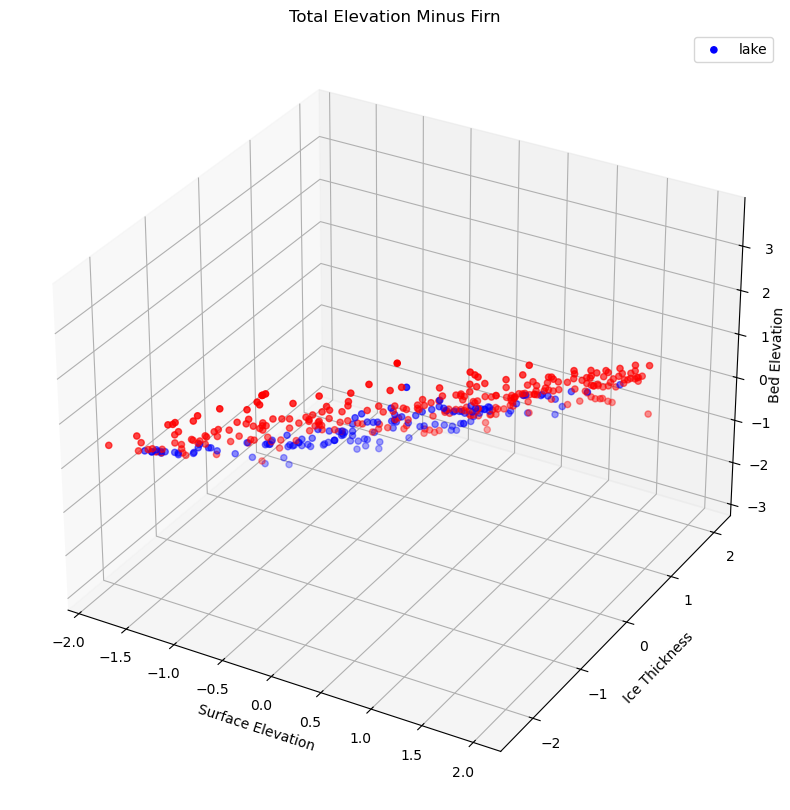

In [21]:
#data visualizations
#lake is blue, nonlake is red
colors=['blue' if value==0 else 'red' for value in dumY]

#bed & surface elevation
plt.scatter(X[:,3], X[:,1],c=colors)
plt.xlabel("Bed Elevation")
plt.ylabel("Ice Surface Elevation")
plt.title("Bed Elevation vs Surface Elevation")
plt.legend(['lake'])
plt.savefig("BedvsSurface.png")
plt.show()

#firn and nonlake vs lake
plt.scatter(X[:,0], dumY)
plt.xlabel("Firn Value")
plt.ylabel("0: Lake, 1: Nonlake")
plt.title("Firn Value vs Classification")
plt.savefig("firnVal.png")
plt.show()

#surface, thickness, bed lake vs nonlake
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 1], X[:, 2],X[:,3], c = colors)
plt.legend(['lake', 'nonlake'])
ax.set_xlabel('Surface Elevation')
ax.set_ylabel('Ice Thickness')
ax.set_zlabel('Bed Elevation')
ax.zaxis.labelpad=-3.5
plt.title('Total Elevation Minus Firn')
plt.savefig("BedSurfThick.png")
plt.show()

## Model Selection - KNeighborsClassifier, Support Vector Machines, Logistic Regression

In [22]:
#split up our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [32]:
#train a KNeighborsClassifier Model
modelK=KNeighborsClassifier(4)
modelK.fit(X_train, y_train)
y_hat=modelK.predict(X_test)
#test to see if our model is at least sort of working
print("Accuracy Score: ", accuracy_score(y_test, y_hat))
print(classification_report(y_test, y_hat))

Accuracy Score:  0.788135593220339
              precision    recall  f1-score   support

        lake       0.69      0.80      0.74        44
     nonlake       0.87      0.78      0.82        74

    accuracy                           0.79       118
   macro avg       0.78      0.79      0.78       118
weighted avg       0.80      0.79      0.79       118



In [24]:
#train a SVM Model
from sklearn.svm import SVC

modelS = SVC(kernel = 'rbf')
modelS.fit(X_train, y_train)
prediction = modelS.predict(X_test)
#I know i should use f1_score, but it keeps throwing an error
print("Accuracy Score: ",accuracy_score(y_test, prediction ))
print(classification_report(y_test, prediction))

Accuracy Score:  0.711864406779661
              precision    recall  f1-score   support

        lake       0.68      0.43      0.53        44
     nonlake       0.72      0.88      0.79        74

    accuracy                           0.71       118
   macro avg       0.70      0.66      0.66       118
weighted avg       0.71      0.71      0.69       118



In [25]:
#train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression

modelL = LogisticRegression()
modelL.fit(X_train, y_train)
predict = modelL.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

Accuracy Score:  0.7627118644067796
              precision    recall  f1-score   support

        lake       0.75      0.55      0.63        44
     nonlake       0.77      0.89      0.82        74

    accuracy                           0.76       118
   macro avg       0.76      0.72      0.73       118
weighted avg       0.76      0.76      0.75       118



### Model Selection Results

The goal of any of our models is to accurately predict whether a point is a subglacial lake or not. We are looking at classifying our objects, thus we will use a supervised classification machine learning algorithm. I tested three different models to determine which fits the data best.

Since the overarching goal of this project is to expand the current inventory of confirmed subglacial lakes, this model should have a larger recall score for the 'lake' target. We see that the K-Neighbors classifier has the highest recall for 'lakes' while still having a reasonable recall score for 'nonlakes'. It is important to note that while SVM and Logistic Regression have decent accuracy scores*, their low 'lake' recall scores mean there is a high proportion of false negatives, thus we will use **K-Neighbors Classifier** as our machine learning algorithm. 

Furthermore, it is understandable that K-Neighbors is the best model because the features of this model are complex geophysical quantities that cannot be modeled using a simple function. Therefore, the relationship between these features and our targets cannot be captured by a simple function.

It is difficult to choose K-Neighbors over Linear Regression because LR has the least amount of false positives, thus the lakes the model identifys are more likely to be lakes. The caveat to this is LR also has more false negatives than K-Neighbors.

*I understand accuracy is not the best function to use for SVM and LR, but f1_score was not working in my code

## Results and Evaluation
As we saw above K-Neighbors Classifier performs best for our model compared to the other model types, but how well does it truly perform?

In [33]:
print("Accuracy Score: ", accuracy_score(y_test, y_hat))
print(classification_report(y_test, y_hat))
print(confusion_matrix(y_test,y_hat))

Accuracy Score:  0.788135593220339
              precision    recall  f1-score   support

        lake       0.69      0.80      0.74        44
     nonlake       0.87      0.78      0.82        74

    accuracy                           0.79       118
   macro avg       0.78      0.79      0.78       118
weighted avg       0.80      0.79      0.79       118

[[35  9]
 [16 58]]


We will evaluate each metric in our classification report: precision, recall, and f1-score.

#### Precision

Precision measures our models ability to not have false positive predictions. For example, the closer the precision value is to $1$, the less false positives we have. For our model, the 'lake' precision score is fairly low at $0.65$ because we had $21$ false positives, meanwhile the 'nonlake' precision score is very high at $0.91$, meaning we have less false positives for nonlakes.  

####  Recall

Recall measures our models ability to find all the true positive objects in our dataset. The closer the value to $1$, the less false negatives we have. For our model the 'lake' recall score is very high at $0.89$, meaning we did not have many false negatives ($5$ to be exact). The 'nonlake' recall score was lower and there were $21$ false negatives for nonlakes. 

#### F1-Score

F1-Score combines our precision and recall values. The higher our value, the more balance between recall and precision, which tells us that we have a model that weights false positives and false negatives similarily. For our model the F1-scores of lakes and nonlakes are similar and fairly large. This shows that for each of our targets the balance between false negatives and false positives is at an acceptable level.    

### Conclusion
The ability to use 

## Ethics

My project does not have any clear ethical or societal impacts because it is located in an area of the world where very few humans reside, and those that do live there are not permanent residents, instead they are mainly researchers and military personnel. However, there are two main impacts we can consider, the impact subglacial lakes have on climate change, and what we can do with knowing where these subglacial lakes are.

If the glaciers in Antarctica and Greenland were to all melt, sea level would rise by approximately 210 feet. This would cause a large increase in coastal erosion and an increase in storm surges, as warming air and water temperatures contribute to more frequent storms, such as hurricanes. So understanding any and all causes of glacial melt, is very important. The faster glaciers flow/move the more frictional heating we have, which leads to more ice melt. The flow of glaciers is extremely dependent on their subglacial hydrology, including subglacial lakes. So if we know exactly where subglacial lakes are, and what geophysical characteristics and featureripresentze them, we can better track them and potentially visit them and collect other valuable data. While this information would not help slow or fix climate change, what it can do is allow us to better track how quickly ice is melting, and what climate change is doing to the ice sheets.  

Additionally, because places like Antarcitica are so cold, they are able to preserve information about the past very well. Subglacial lakes contain information on ancient climate, and ancient microorganisms, who have been able to survive for over thousands of years. Similar to how ice cores provide information on how greenhouse gasses have changed throughout the past, we can look at the water in these lakes to gain vital information on atmospheric conditions. 

While neither of these considerations directly impact our daily lives, they can provide scientists with vital information on how climate change is 
impacting the world, and what that might mean for our future.

## Future Work

The ice-hydrology of Antarctica is very complex, with many features that go far beyond what we have used in this model. A valuable next step would be to find these other features and incorporate them into a future model. Another possible step would be to explore more complex classification algorithms such as random forests or neural networks. KNN classifies an unclassified object by determining its closest classified neighbor who shares similar feature values, whereas neural networks utilize interconnected and deep layers to identify patterns between features and then classify our objects. Thus a neural network might be able to better analyze the complex connections between our features. 

There are two types of subglacial lakes, active and inactive. Active subglacial lakes drain and fill continuously, contributing to short and long-term glacier flow dynamics. Inactive lakes remain stagnant, not draining or filling and thus behave very differently from active lakes. Thus a next step could be to take our classifed subglacial lakes and further break them down into active and inactive subglacial lakes. We would probably need more data to determine this, specifically one showing ice height changes. 